In [1]:
from load_prep_sample import prep_sample
from preprocessing import preproc_img
from VGG16_kt import build_model_VGG16

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner import RandomSearch
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D


2024-04-26 08:53:24.973951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 08:53:25.112459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 08:53:26.089340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
df_images = pd.read_csv('df_images.csv')
df_masks = pd.read_csv('df_masks.csv')

In [ ]:
# importation et preprocessing des images
data, target = preproc_img(df_images, df_masks, n_img=900, normalize=True, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [3]:
tuner = RandomSearch(
        build_model_VGG16,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        overwrite = True,
        directory='my_dir',
        project_name="VGG16final", #changer pour un nom dynamique en fonction du nom du modèle importé
        )

2024-04-26 08:54:03.411899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 08:54:03.509118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 08:54:03.509176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 08:54:03.511292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 08:54:03.511351: I external/local_xla/xla/stream_executor

In [4]:
tuner.search(X_train, 
                y_train, 
                validation_data=(X_test, y_test), 
                epochs=20)

Trial 20 Complete [00h 03m 13s]
val_accuracy: 0.9433333277702332

Best val_accuracy So Far: 0.949999988079071
Total elapsed time: 01h 01m 22s


In [5]:
best_trials = tuner.oracle.get_best_trials(num_trials=10)


results = []
   
for trial in best_trials:
    trial_data = trial.hyperparameters.values
    trial_data['score'] = trial.score
    results.append(trial_data)
   
df_results = pd.DataFrame(results)

df_results

,units,dropout,learning_rate,score
0,1024,0.0,0.00010,0.950000
1,512,0.4,0.00010,0.948889
2,2056,0.4,0.00010,0.947778
3,256,0.3,0.00001,0.943333
4,128,0.1,0.00001,0.943333
5,256,0.2,0.00001,0.942222
6,256,0.4,0.00010,0.941111
7,256,0.4,0.00001,0.940000
8,128,0.0,0.00001,0.937778
9,256,0.1,0.00001,0.937778


In [16]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
new_model = build_model_VGG16(best_hyperparameters)

In [17]:
history = new_model.fit(X_train, 
                        y_train, 
                        epochs=30, 
                        batch_size= 64,
                        validation_data=(X_test, y_test))

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.5930 - loss: 0.9348 - val_accuracy: 0.8433 - val_loss: 0.4100
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.8650 - loss: 0.3672 - val_accuracy: 0.9067 - val_loss: 0.2610
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.9216 - loss: 0.2243 - val_accuracy: 0.8267 - val_loss: 0.4068
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8959 - loss: 0.2787 - val_accuracy: 0.8856 - val_loss: 0.3097
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9377 - loss: 0.1706 - val_accuracy: 0.9244 - val_loss: 0.2147
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9600 - loss: 0.1083 - val_accuracy: 0.9033 - val_loss: 0.2514
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9585 - loss: 0.1304 - val_accuracy: 0.9389 - val_loss: 0.1735
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.9747 - loss: 0.0807 - val_accuracy: 0

/tmp/ipykernel_421646/3058597897.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(history.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
/tmp/ipykernel_421646/3058597897.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')


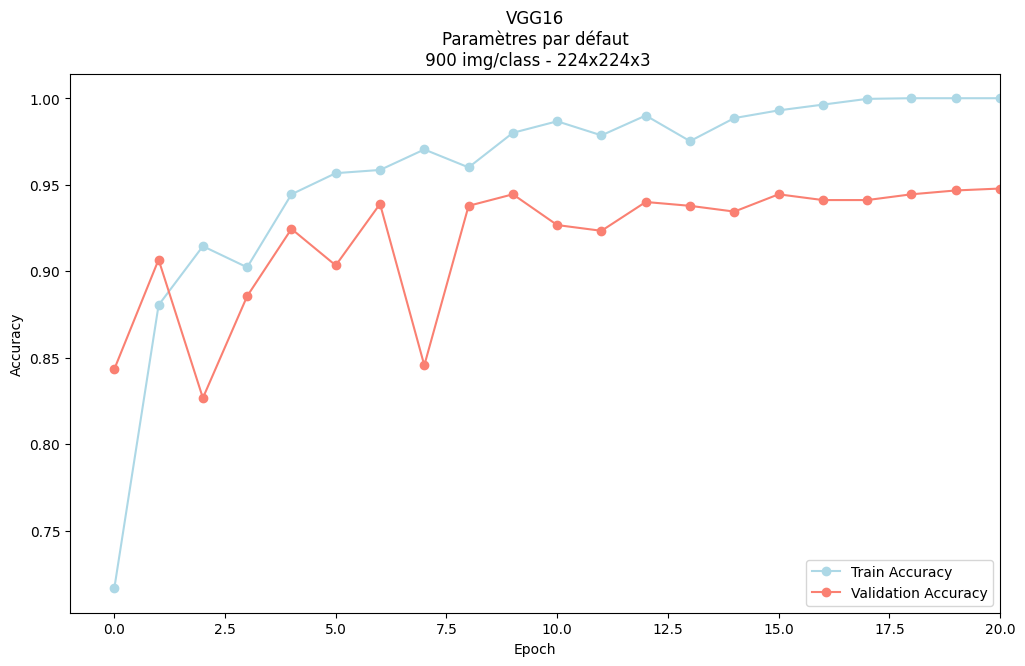

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'],'bo-', label='Train Accuracy',color='lightblue')
plt.plot(history.history['val_accuracy'],'ro-', label='Validation Accuracy',color='salmon')
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1,20)
plt.legend(loc='lower right')
plt.show()

In [19]:
# Prédiction sur l'ensemble de test
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       242
        Lung       0.94      0.91      0.92       216
      Normal       0.89      0.92      0.90       216
       Viral       0.99      0.99      0.99       226

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



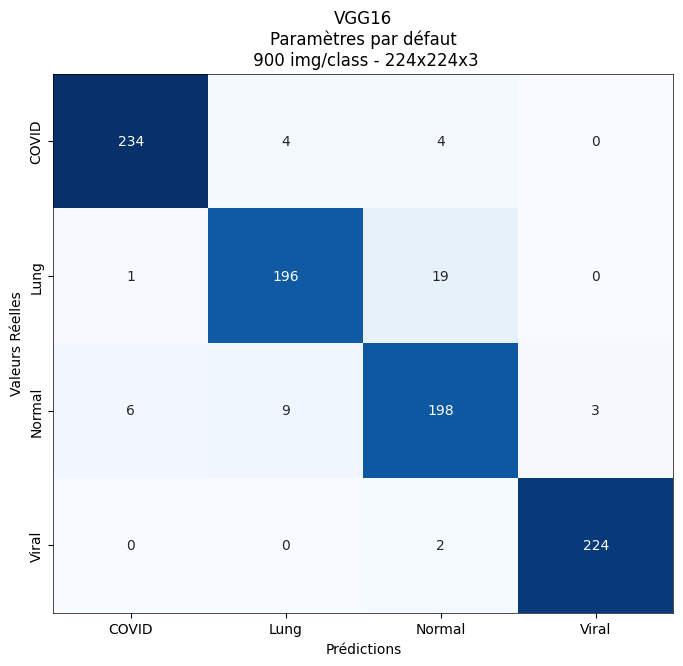

In [20]:
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['COVID', 'Lung', 'Normal', 'Viral'],
            yticklabels=['COVID', 'Lung', 'Normal', 'Viral'])
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

In [21]:
new_model.save('VGG16_finetuned_test.h5')

In [22]:
import pickle

In [23]:
with open('model_historyVGG16_test.pkl', 'wb') as file:
    pickle.dump(history.history, file)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


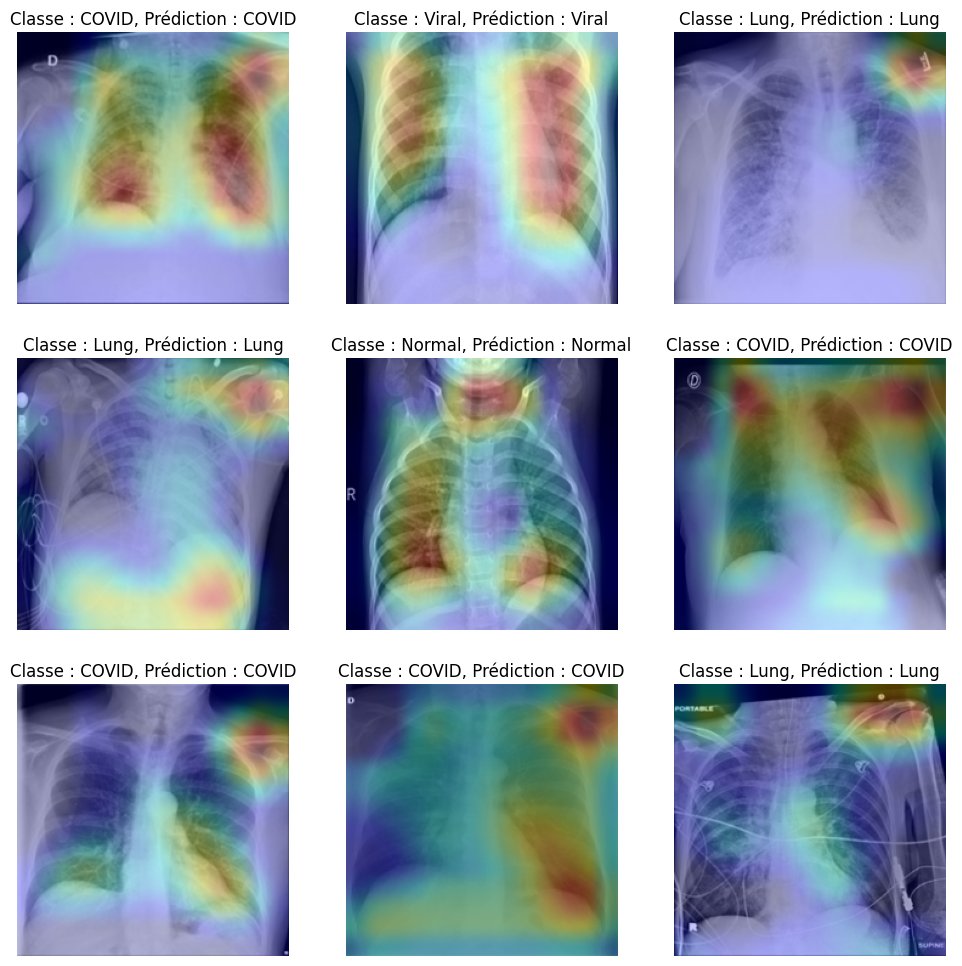

In [45]:
from grad_cam import make_gradcam_heatmap, save_and_display_gradcam
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.layers import Conv2D
     
classes = ['COVID', 'Lung', 'Normal', 'Viral']

y_test_classes = np.argmax(y_test, axis=1)
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Désactivation de l'activation softmax de la dernière couche
new_model.layers[-1].activation = None

# Identification du nom de la dernière couche Conv2D
last_conv_layer_name = None
for layer in reversed(new_model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

# Préparation de la figure pour afficher 5 images
plt.figure(figsize=(12, 12))  # Largeur, hauteur en pouces
for i in range(9):
    R = random.randint(0, len(X_test) - 1)
    base_img = X_test[R]
    heatm_img = np.expand_dims(base_img, axis=0)
    img_cam = np.uint8(base_img * 255)  # Conversion de l'image pour affichage

    # Prédiction sans la couche softmax activée
    preds = new_model.predict(heatm_img)
    heatmap = make_gradcam_heatmap(heatm_img, new_model, last_conv_layer_name)
    grad_img = save_and_display_gradcam(img_cam, heatmap)

    # Vérification de la vraie classe et de la prédiction
    vraie = classes[y_test_classes[R]]
    prediction = classes[y_pred_classes[R]]

    # Affichage dans un sous-graphique
    plt.subplot(3, 3, i + 1)  # 1 ligne, 5 colonnes, ième position
    plt.imshow(grad_img)
    plt.title(f"Classe : {vraie}, Prédiction : {prediction}")
    plt.axis('off')  # Désactivation des axes pour une meilleure visibilité

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


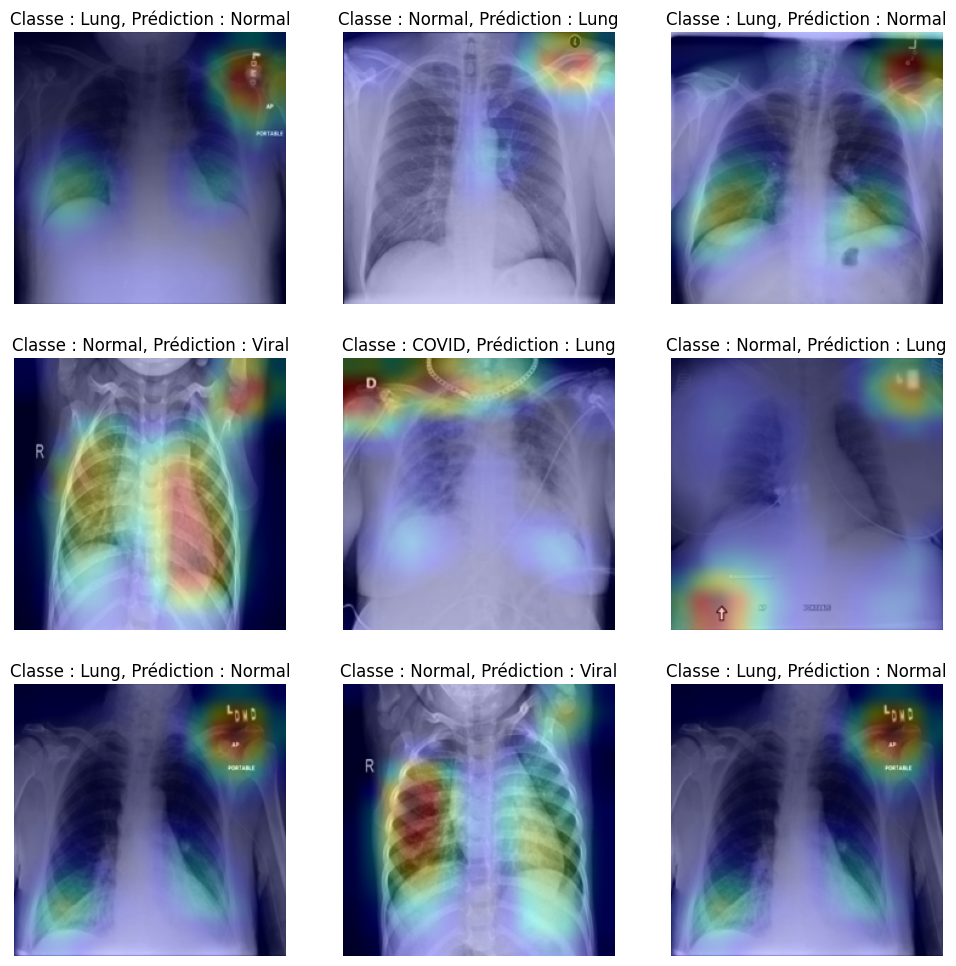

In [46]:
from grad_cam import make_gradcam_heatmap, save_and_display_gradcam
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.layers import Conv2D

classes = ['COVID', 'Lung', 'Normal', 'Viral']

y_test_classes = np.argmax(y_test, axis=1)
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

indices_diff = np.where(y_test_classes != y_pred_classes)[0]

# Désactivation de l'activation softmax de la dernière couche
new_model.layers[-1].activation = None

# Identification du nom de la dernière couche Conv2D
last_conv_layer_name = None
for layer in reversed(new_model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

# Préparation de la figure pour afficher 5 images
plt.figure(figsize=(12, 12))  # Largeur, hauteur en pouces
for i in range(9):
    R = random.choice(indices_diff)
    base_img = X_test[R]
    heatm_img = np.expand_dims(base_img, axis=0)
    img_cam = np.uint8(base_img * 255)  # Conversion de l'image pour affichage

    # Prédiction sans la couche softmax activée
    preds = new_model.predict(heatm_img)
    heatmap = make_gradcam_heatmap(heatm_img, new_model, last_conv_layer_name)
    grad_img = save_and_display_gradcam(img_cam, heatmap)

    # Vérification de la vraie classe et de la prédiction
    vraie = classes[y_test_classes[R]]
    prediction = classes[y_pred_classes[R]]

    # Affichage dans un sous-graphique
    plt.subplot(3, 3, i + 1)  # 1 ligne, 5 colonnes, ième position
    plt.imshow(grad_img)
    plt.title(f"Classe : {vraie}, Prédiction : {prediction}")
    plt.axis('off')  # Désactivation des axes pour une meilleure visibilité

plt.show()